Find the minimally-complex Support Vector Machine that will classify the dataset with 100% accuracy. Use the following hyperparameters:


 - C: The C parameter controls the relative weighting of classification error and margin error. Recall that large C means more focus is placed on classifying points correctly, whereas small C focuses more on establishing a large margin.
 
- kernel: The kernel. The most commonly-used ones are linear, poly, and rbf.

- degree: If the kernel is polynomial, this is the max degree of the monomial terms.

- gamma: If the kernel is rbf, this is the gamma parameter that controls how narrow or wide the “mountains” are. Larger gamma means “taller peaks” and a higher likelihood of overfitting.

In [1]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [2]:
%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.style.use('tableau-colorblind10')

In [3]:
data_df = pd.read_csv('data.txt', sep = ',', header=None)
print(str(data_df.shape[0]) + ' data points')
print(data_df[2].value_counts())

96 data points
1    64
0    32
Name: 2, dtype: int64


In [4]:
data = np.asarray(data_df)


Place the features into X, the labels into y.

In [5]:
X = data[:,0:2]
y = data[:,2]

Set up visuals.

In [6]:
cmap_light = ListedColormap(['#FFCCCC', '#CCCCFF'])
cmap_bold  = ListedColormap(['#FF1111', '#1111FF'])

## Visualize the Dataset


<IPython.core.display.Javascript object>


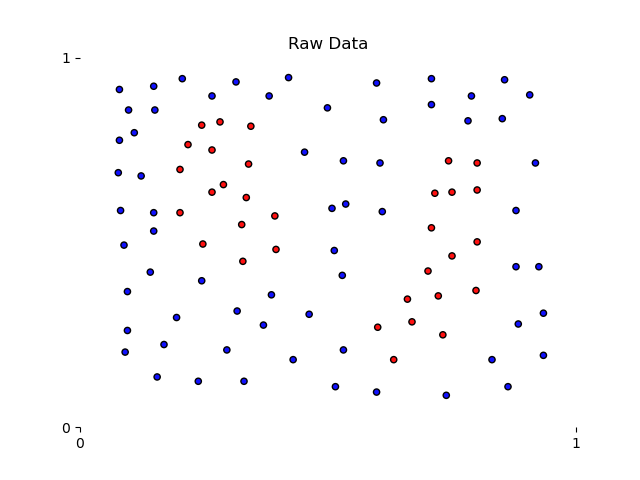

In [26]:
def plot_classifier_regions_and_data(model=None,
                                     results_row=None):    
    if model is not None:
        mesh_step_size = .005
        
        
        xx, yy = np.meshgrid(np.arange(0, 1, mesh_step_size),
                             np.arange(0, 1, mesh_step_size))
        Z = model.predict(np.c_[xx.ravel(), 
                                yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    if results_row is not None:
        plt.title('{} kernel, C={}, degree={}, gamma={}\nAccuracy={:0.2}'.format(results_row['kernel'].title(),
                                                                                 results_row['c'],
                                                                                 results_row['degree'],
                                                                                 results_row['gamma'],
                                                                                 float(results_row['acc'])))

    plot_symbol_size = 20
    plt.scatter(X[:, 0],
                X[:, 1],
                s=plot_symbol_size,
                c=y,
                cmap=cmap_bold, 
                edgecolor='black')

    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.xticks([0.0,1.0])
    plt.yticks([0.0,1.0])
plt.figure()
plot_classifier_regions_and_data()
plt.title('Raw Data');

### Train and Benchmark a Default SVM
Default:

C = 1.0

kernel = ‘rbf’

degree = 3

gamma = ‘scale’

<IPython.core.display.Javascript object>


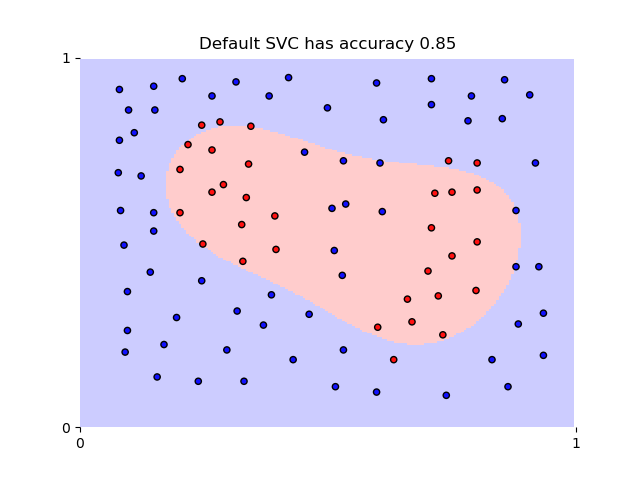

In [27]:
model = SVC()
model.fit(X, y)
y_pred = model.predict(X)
plt.figure()
plot_classifier_regions_and_data(model)
plt.title('Default SVC has accuracy {:1.2}'.format(accuracy_score(y, y_pred)));

### Exhaustively Search the Hyperparameter Space

In [28]:
results = pd.DataFrame(columns=['c',
                                'kernel',
                                'degree',
                                'gamma',
                                'acc'])

In [29]:
def train_model_save_results(c, 
                             kernel, 
                             degree=0, 
                             gamma='auto'):
    global results
    
    model = (SVC(C=c,
                 kernel=kernel,
                 degree=degree,
                 gamma=gamma))
    model.fit(X, y)
    y_pred = model.predict(X)

    acc =  accuracy_score(y, y_pred)
    
    results = results.append(pd.Series([c,
                                        kernel,
                                        degree,
                                        gamma,
                                        acc],
                                       index=results.columns),
                             ignore_index=True)
    
    models.append(model)

In [30]:
models = list()
for c in np.logspace(-6, 6, 13):
    for kernel in ['linear', 'poly', 'rbf']:
        if kernel == 'linear':
            train_model_save_results(c,
                                     kernel,
                                     degree=0,
                                     gamma='auto')
        elif kernel == 'poly':
            for d in [2, 3, 4, 5, 6, 7]:
                degree = d
                train_model_save_results(c,
                                         kernel,
                                         degree=d,
                                         gamma='auto')
        elif kernel == 'rbf':
            for g in np.logspace(-5, 5, 11):
                gamma = g
                train_model_save_results(c,
                                         kernel,
                                         degree=0,
                                         gamma=g)

### Examine Results

234 models were changed, all of which are accessible in the models list.

In [31]:
results.loc[results['acc']  > 0.6, 'acc_cat'] = '0.6+'
results.loc[results['acc']  > 0.8, 'acc_cat'] = '0.8+'
results.loc[results['acc']  > 0.9, 'acc_cat'] = '0.9+'
results.loc[results['acc'] == 1.0, 'acc_cat'] = '1.0'

In [32]:
results.head()


,c,kernel,degree,gamma,acc,acc_cat
0,0.000001,linear,0,auto,0.666667,0.6+
1,0.000001,poly,2,auto,0.666667,0.6+
2,0.000001,poly,3,auto,0.666667,0.6+
3,0.000001,poly,4,auto,0.666667,0.6+
4,0.000001,poly,5,auto,0.666667,0.6+


In [33]:
(pd.pivot_table(results[['kernel','acc_cat']],
                index='kernel',
                columns='acc_cat',
                aggfunc=len)
 .fillna(0).astype(int).replace({0:'-'}))

acc_cat,0.6+,0.8+,0.9+,1.0
kernel,,,,
linear,13,-,-,-
poly,78,-,-,-
rbf,96,9,2,36


The RBF kernel is the only one able to attain more than 80% accuracy.

### Visualize Classifications

### 80%+ Classifiers

In [34]:
(results[(results['acc_cat']=='0.8+')]
 .sort_values('acc'))

,c,kernel,degree,gamma,acc,acc_cat
138,10.0,rbf,0,1,0.812500,0.8+
208,100000.0,rbf,0,0.01,0.812500,0.8+
173,1000.0,rbf,0,0.1,0.822917,0.8+
191,10000.0,rbf,0,0.1,0.833333,0.8+
209,100000.0,rbf,0,0.1,0.833333,0.8+
226,1000000.0,rbf,0,0.01,0.833333,0.8+
156,100.0,rbf,0,1,0.843750,0.8+
227,1000000.0,rbf,0,0.1,0.854167,0.8+
174,1000.0,rbf,0,1,0.875000,0.8+


<IPython.core.display.Javascript object>


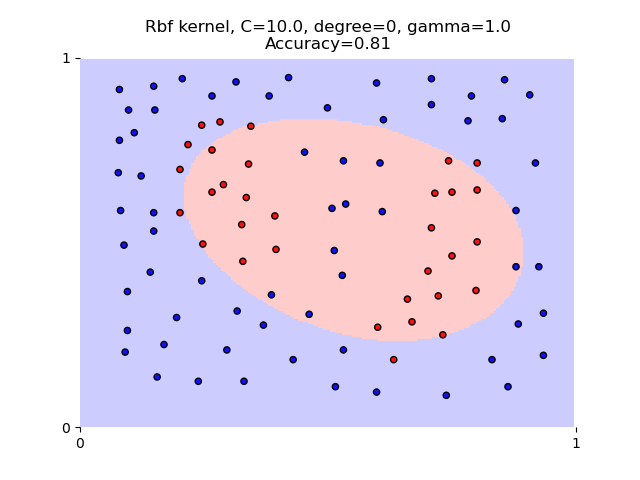

In [35]:
plt.figure()
plot_classifier_regions_and_data(models[138],
                                 results.iloc[138])

<IPython.core.display.Javascript object>


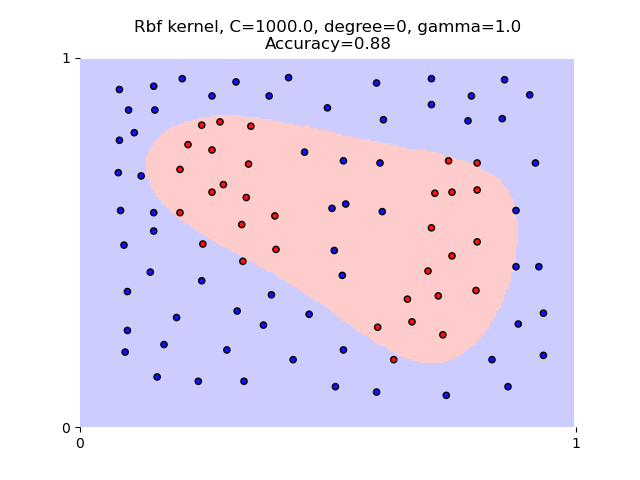

In [36]:
plt.figure()
plot_classifier_regions_and_data(models[174],
                                 results.iloc[174])

### 90%+ Classifiers


In [37]:
(results[(results['acc_cat']=='0.9+')]
 .sort_values('acc'))

,c,kernel,degree,gamma,acc,acc_cat
121,1.0,rbf,0,10,0.906250,0.9+
192,10000.0,rbf,0,1,0.979167,0.9+


<IPython.core.display.Javascript object>


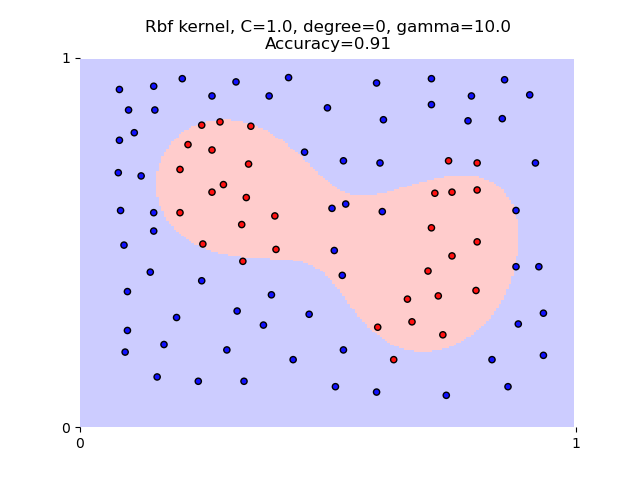

In [38]:
plt.figure()
plot_classifier_regions_and_data(models[121],
                                 results.iloc[121])

<IPython.core.display.Javascript object>


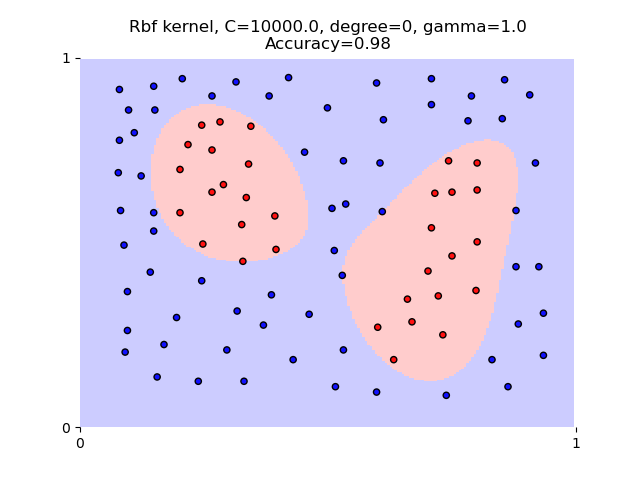

In [39]:
plt.figure()
plot_classifier_regions_and_data(models[192],
                                 results.iloc[192])

### 100% Classifiers

There are several RBF classifiers that had a score of 100%.

The “simplest” classifiers have:

- **small gamma** and therefore relatively low likelihood of overfitting, and

- **small C**, and therefore relatively large possible margin and higher likelihood of generalizing to other, similar datasets.

In [40]:
results[results['acc_cat']=='1.0'].shape[0]


36

In [41]:
(results[(results['acc_cat']=='1.0')]
 .sort_values(['gamma',
               'c'])
 .iloc[[0]])

,c,kernel,degree,gamma,acc,acc_cat
210,100000.0,rbf,0,1,1.0,1.0


In [42]:
(results[(results['acc_cat']=='1.0')]
 .sort_values(['c',
               'gamma'])
 .iloc[[0]])

,c,kernel,degree,gamma,acc,acc_cat
122,1.0,rbf,0,100,1.0,1.0


<IPython.core.display.Javascript object>


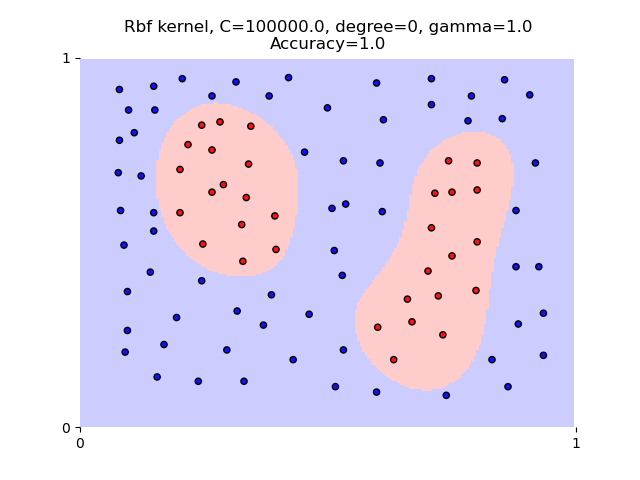

In [43]:
plt.figure()
plot_classifier_regions_and_data(models[210],
                                 results.iloc[210])

<IPython.core.display.Javascript object>


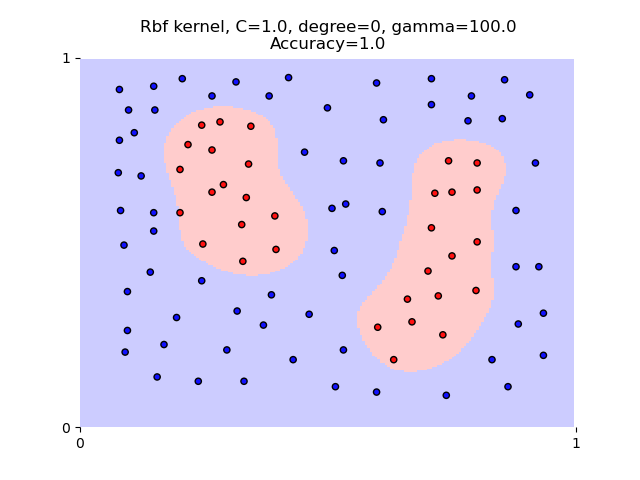

In [44]:
plt.figure()
plot_classifier_regions_and_data(models[122],
                                 results.iloc[122])